In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-04-03 23:54:18--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.38.8, 54.231.198.16, 52.216.218.240, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.38.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  25.9MB/s    in 0.5s    

2025-04-03 23:54:19 (25.9 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**The analysis of Jena weather dataset data**


In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()

lines_data_data = data.split("\n")
header = lines_data_data[0].split(",")
lines_data_data= lines_data_data[1:]
print(header)
print(len(lines_data_data))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Viewing the data**

In [4]:
!pip install numpy

In [5]:
import numpy as np

In [6]:
temperature = np.zeros((len(lines_data_data),))
raw_data = np.zeros((len(lines_data_data), len(header) - 1))
for i, line in enumerate(lines_data_data):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Temperature time series charting**

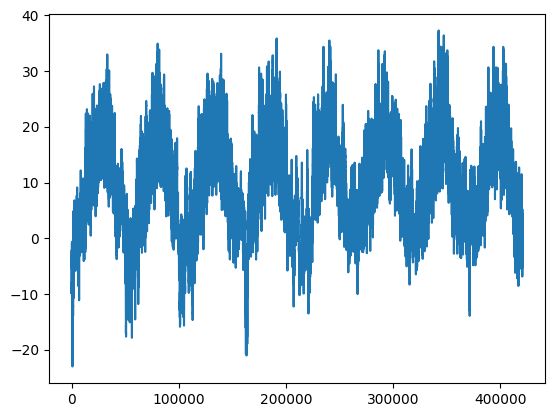

In [7]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the temperature data for the first ten days**


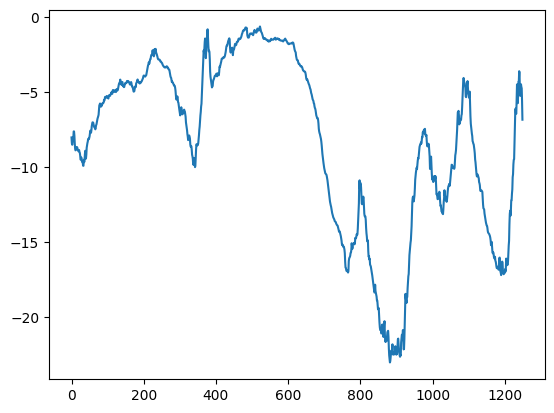

In [8]:
plt.plot(range(1250), temperature[:1250])


**Determine the sample numbers for each data split**

In [9]:
num_training_samples = int(0.2 * len(raw_data))
num_validation_samples = int(0.15 * len(raw_data))
num_test_samples = len(raw_data) - num_training_samples - num_validation_samples
print("num_training_samples:", num_training_samples)
print("num_validation_samples:", num_validation_samples)
print("num_test_samples:", num_test_samples)


num_training_samples: 84090
num_validation_samples: 63067
num_test_samples: 273294


**Preparing the Data**

Normalization of Data

In [10]:
mean = raw_data[:num_training_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_training_samples].std(axis=0)
raw_data /= std
import numpy as np
from tensorflow import keras
initial_sequence = np.arange(10)
dummy_data = keras.utils.timeseries_dataset_from_array(
data=initial_sequence[:-2],
targets=initial_sequence[2:],
sequence_length=4,
batch_size=1,
)
for inputs, targets in dummy_data:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2, 3] 2
[1, 2, 3, 4] 3
[2, 3, 4, 5] 4
[3, 4, 5, 6] 5
[4, 5, 6, 7] 6


**The development of real-time datasets serves for both training and validating and testing purposes.**

In [11]:
sampling_rate = 4
sequence_length = 80
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 128

training_dataset = keras.utils.timeseries_dataset_from_array(
raw_data[:-delay],
targets=temperature[delay:],
sampling_rate=sampling_rate,
sequence_length=sequence_length,
shuffle=True,
batch_size=batch_size,
start_index=0,
end_index=num_training_samples)

validation_dataset = keras.utils.timeseries_dataset_from_array(
raw_data[:-delay],
targets=temperature[delay:],
sampling_rate=sampling_rate,
sequence_length=sequence_length,
shuffle=True,
batch_size=batch_size,
start_index=num_training_samples,
end_index=num_training_samples + num_validation_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
raw_data[:-delay],
targets=temperature[delay:],
sampling_rate=sampling_rate,
sequence_length=sequence_length,
shuffle=True,
batch_size=batch_size,
start_index=num_training_samples + num_validation_samples)

**Reviewing the results generated by one of our selected datasets**

In [12]:
for samples, targets in training_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break


samples shape: (128, 80, 14)
targets shape: (128,)


**A reasonable baseline that isn't machine learning**

Establishing the suitable baseline for MAE calculation.


In [13]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen
print(f"Validation MAE: {evaluate_naive_method(validation_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")


Validation MAE: 4.53
Test MAE: 4.08


**We can explore a fundamental machine-learning model at this time.**

**A tightly connected model functions through training as well as assessment procedures.**

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# Remove the Flatten layer
# x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(inputs) # Apply Dense layer directly to the input
#x = layers.Flatten()(x) # Apply Flatten after Dense layer or another suitable layer

# Reshape the output of the Dense layer using Reshape before flattening
# or global average pooling if it is appropriate for your data
x = layers.Reshape((-1,16))(x)  # Reshape to (None, 80*16)
x = layers.Flatten()(x)

outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_dense.keras") # Load the model with the .keras extension
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - loss: 20.2331 - mae: 3.2388 - val_loss: 9.7477 - val_mae: 2.4249
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - loss: 8.3244 - mae: 2.2415 - val_loss: 9.2283 - val_mae: 2.3510
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - loss: 7.8561 - mae: 2.1754 - val_loss: 9.1305 - val_mae: 2.3437
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 7.5959 - mae: 2.1402 - val_loss: 9.3163 - val_mae: 2.4020
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - loss: 7.3967 - mae: 2.1146 - val_loss: 9.0567 - val_mae: 2.3371
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - loss: 7.2376 - mae: 2.0952 - val_loss: 8.8255 - val_mae: 2.3210
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - loss: 7.1060 - mae: 2.0791 - val_loss: 8.8777 - val_mae: 2.3365
Epoch 8/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - loss: 7.0568 - mae: 2.0720 - val_loss: 9.0502 - val_mae: 2.3436
Epoch 9/10
655/655 ━━━━━━━━━━━━━━━━━━━━

**Results**

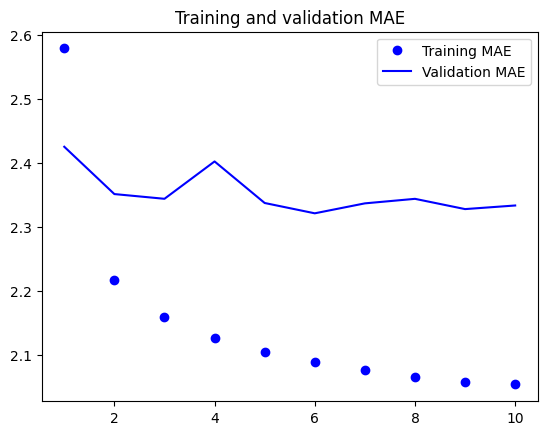

In [15]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
validation_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, validation_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()


**A 1D convolutional model served as the main objective for implementation.**

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras", # Change the filepath to end with .keras
                                    save_best_only=True)
                                    # Removed save_format='tf' as it is not supported in older versions of Keras
]
# ... (rest of the code remains the same) ...
#model = keras.models.load_model("jena_conv.keras") # Load the model with the .keras extension
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
epochs=10,
validation_data=validation_dataset,
callbacks=callbacks)
model = keras.models.load_model("jena_conv.keras") #Fixed the file name
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - loss: 23.3393 - mae: 3.5501 - val_loss: 11.6514 - val_mae: 2.6726
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 27s 42ms/step - loss: 9.7162 - mae: 2.4281 - val_loss: 12.5205 - val_mae: 2.7749
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - loss: 8.7896 - mae: 2.3192 - val_loss: 10.7511 - val_mae: 2.5677
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - loss: 8.0336 - mae: 2.2209 - val_loss: 12.1040 - val_mae: 2.7071
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - loss: 7.6371 - mae: 2.1708 - val_loss: 10.4915 - val_mae: 2.5460
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - loss: 7.2154 - mae: 2.1081 - val_loss: 10.7931 - val_mae: 2.5918
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 27s 41ms/step - loss: 7.0165 - mae: 2.0823 - val_loss: 11.4157 - val_mae: 2.6540
Epoch 8/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - loss: 6.7722 - mae: 2.0553 - val_loss: 11.5822 - val_mae: 2.6693
Epoch 9/10
655/655 ━━━━━━━━━━━━

**LSTM-Based Model Represents the Initial Recurring Baseline**

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", # Changed the filepath to jena_lstm.keras
                                    save_best_only=True) # remove save_format argument
]
# The file 'jena_lstm.keras' might not exist initially,
# leading to a FileNotFoundError when trying to load it.
# We only load the model if it exists.
import os
if os.path.exists("jena_lstm.keras"):
    model = keras.models.load_model("jena_lstm.keras")
else:
    print("Model file not found. Training from scratch.")

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
epochs=10,
validation_data=validation_dataset,
callbacks=callbacks)
# Loading the best model which is saved during training
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Model file not found. Training from scratch.
Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 44s 65ms/step - loss: 82.2629 - mae: 6.9514 - val_loss: 17.2649 - val_mae: 3.2294
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - loss: 13.9501 - mae: 2.7743 - val_loss: 11.3329 - val_mae: 2.6498
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 80s 62ms/step - loss: 8.2758 - mae: 2.2114 - val_loss: 11.0002 - val_mae: 2.5644
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 42s 65ms/step - loss: 7.3781 - mae: 2.0976 - val_loss: 11.4249 - val_mae: 2.6060
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 43s 65ms/step - loss: 6.8045 - mae: 2.0228 - val_loss: 11.3663 - val_mae: 2.6164
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - loss: 6.4384 - mae: 1.9667 - val_loss: 11.1152 - val_mae: 2.6023
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 81s 62ms/step - loss: 6.1252 - mae: 1.9171 - val_loss: 11.2813 - val_mae: 2.6426
Epoch 8/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 43s 65ms/step - loss: 5.9112 - mae: 1.8880 - val_loss: 11.3244 - v

**Recurrent neural network detection A NumPy RNN implementation**

In [18]:
import numpy as np
timesteps = 50
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

**The recurrent layers of Keras includes An RNN layer that supports any sequence length**

In [19]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)


**The RNN layer delivers information from only its final step of operation**

In [20]:
num_features = 14
steps = 80
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)


(None, 16)


**The RNN layer generates an entire sequence of output values.**

In [21]:
num_features = 14
steps = 80
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)


(None, 80, 16)


**Stacking tiers for Recurrent neural networks**

In [22]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

**Researchers extensively use recurrent neural networks while designing overfitting management methodologies for frequent dropout situations to work with a dropout-regularized long short-term memory (LSTM).**

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.15)(inputs)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", # Changed filepath to end with .keras
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
epochs=30,
validation_data=validation_dataset,
callbacks=callbacks)


Epoch 1/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 62s 90ms/step - loss: 90.9986 - mae: 7.4142 - val_loss: 19.1361 - val_mae: 3.3590
Epoch 2/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 60s 91ms/step - loss: 20.4323 - mae: 3.4117 - val_loss: 11.2555 - val_mae: 2.6349
Epoch 3/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 61s 92ms/step - loss: 14.7797 - mae: 2.9594 - val_loss: 10.2474 - val_mae: 2.5038
Epoch 4/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 59s 90ms/step - loss: 13.3530 - mae: 2.8251 - val_loss: 10.0267 - val_mae: 2.4824
Epoch 5/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 84s 93ms/step - loss: 12.9522 - mae: 2.7832 - val_loss: 9.7885 - val_mae: 2.4432
Epoch 6/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 62s 94ms/step - loss: 12.6504 - mae: 2.7540 - val_loss: 9.7728 - val_mae: 2.4488
Epoch 7/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 60s 92ms/step - loss: 12.2345 - mae: 2.7066 - val_loss: 9.7992 - val_mae: 2.4526
Epoch 8/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 59s 91ms/step - loss: 11.9826 - mae: 2.6713 - val_loss: 9.7052 - val_mae: 2.4340
Epoch 9/30
655/655 ━━━━━━━━━

**The research evaluates training and evaluation of a GRU model with dropout regularization while using recurrent layer stacking.**

In [29]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16, recurrent_dropout=0.2, return_sequences=True)(inputs)
x = layers.GRU(16, recurrent_dropout=0.2)(x)
x = layers.Dropout(0.2 )(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras", # Changed the filepath to end with .keras
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
epochs=30,
validation_data=validation_dataset,
callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras") # Changed the file path to have the correct .keras extension
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 99s 142ms/step - loss: 72.1536 - mae: 6.4556 - val_loss: 14.8676 - val_mae: 2.9728
Epoch 2/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 91s 139ms/step - loss: 15.6541 - mae: 2.9964 - val_loss: 10.1935 - val_mae: 2.5105
Epoch 3/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 95s 145ms/step - loss: 11.4813 - mae: 2.6318 - val_loss: 9.9058 - val_mae: 2.4679
Epoch 4/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 92s 140ms/step - loss: 10.6426 - mae: 2.5371 - val_loss: 9.8154 - val_mae: 2.4541
Epoch 5/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 144s 143ms/step - loss: 10.2715 - mae: 2.4919 - val_loss: 9.8020 - val_mae: 2.4483
Epoch 6/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 93s 142ms/step - loss: 9.9300 - mae: 2.4498 - val_loss: 10.2843 - val_mae: 2.5178
Epoch 7/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 143s 144ms/step - loss: 9.6904 - mae: 2.4239 - val_loss: 9.7029 - val_mae: 2.4266
Epoch 8/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 93s 142ms/step - loss: 9.4569 - mae: 2.3994 - val_loss: 9.7821 - val_mae: 2.4377
Epoch 9/30
655/655 ━━━

**Bilateral LSTM training combines RNNs to obtain new approaches in assessment and learning processes.**

In [30]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(8))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(training_dataset,
epochs=10,
validation_data=validation_dataset)


Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 85s 81ms/step - loss: 88.5620 - mae: 7.3164 - val_loss: 17.9601 - val_mae: 3.3372
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 53s 81ms/step - loss: 14.8903 - mae: 2.9224 - val_loss: 12.6852 - val_mae: 2.8140
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 52s 80ms/step - loss: 9.3557 - mae: 2.3699 - val_loss: 11.9580 - val_mae: 2.7095
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 83s 81ms/step - loss: 7.9925 - mae: 2.1980 - val_loss: 11.5596 - val_mae: 2.6570
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 53s 80ms/step - loss: 7.2951 - mae: 2.1009 - val_loss: 11.3935 - val_mae: 2.6377
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 60s 91ms/step - loss: 6.7880 - mae: 2.0211 - val_loss: 11.4706 - val_mae: 2.6448
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 75s 80ms/step - loss: 6.4329 - mae: 1.9689 - val_loss: 11.1716 - val_mae: 2.6117
Epoch 8/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 51s 78ms/step - loss: 6.1944 - mae: 1.9376 - val_loss: 11.6801 - val_mae: 2.6768
Epoch 9/10
655/655 ━━━━━━━━━━━